In [1]:
import scipy.io
from matplotlib import pyplot as plt

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
import numpy as np
from numpy.fft import fft, ifft
from scipy import signal as sig
from scipy.signal import hilbert
from scipy.signal import firls
from scipy.stats.mstats import zscore

In [2]:
from google.colab import files # if you use google.colab
uploaded = files.upload()

Saving sampleEEGdata.mat to sampleEEGdata (1).mat


In [3]:
data = scipy.io.loadmat('sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]

# Task 1



In [4]:
def make_wavelet(frequency, subplt):

    time = np.arange(-1,1 + 1/EEGsrate,1/EEGsrate)
    hz = np.linspace(0,EEGsrate/2,(len(time)//2)+1);
    s = (4/(2*pi*frequency))**2 #s squared here rather than next line
    wavelet = exp(2*1j*pi*frequency*time) * exp(-time**2./(2*s)/frequency)

    n_wavelet = len(wavelet)
    n_data = EEGpnts
    n_convolution = n_wavelet + n_data-1
    half_of_wavelet_size = len(wavelet)//2

    fft_wavelet = fft(wavelet,n_convolution)
    fft_data = fft(np.squeeze(EEGdata[46,:,]),n_convolution)# FCz

    fft_data = np.mean(fft_data, axis=0)

    convolution_result_fft = ifft(fft_wavelet*fft_data,n_convolution)

    convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
    subplt.plot(EEGtimes,np.real(convolution_result_fft))
    subplt.set_xlabel('Time (ms)')
    subplt.set_ylabel(r'$Voltage (\mu V)$')
    subplt.set_title( 'Projection onto real axis is filtered signal at ' + str(frequency) + ' Hz.' )



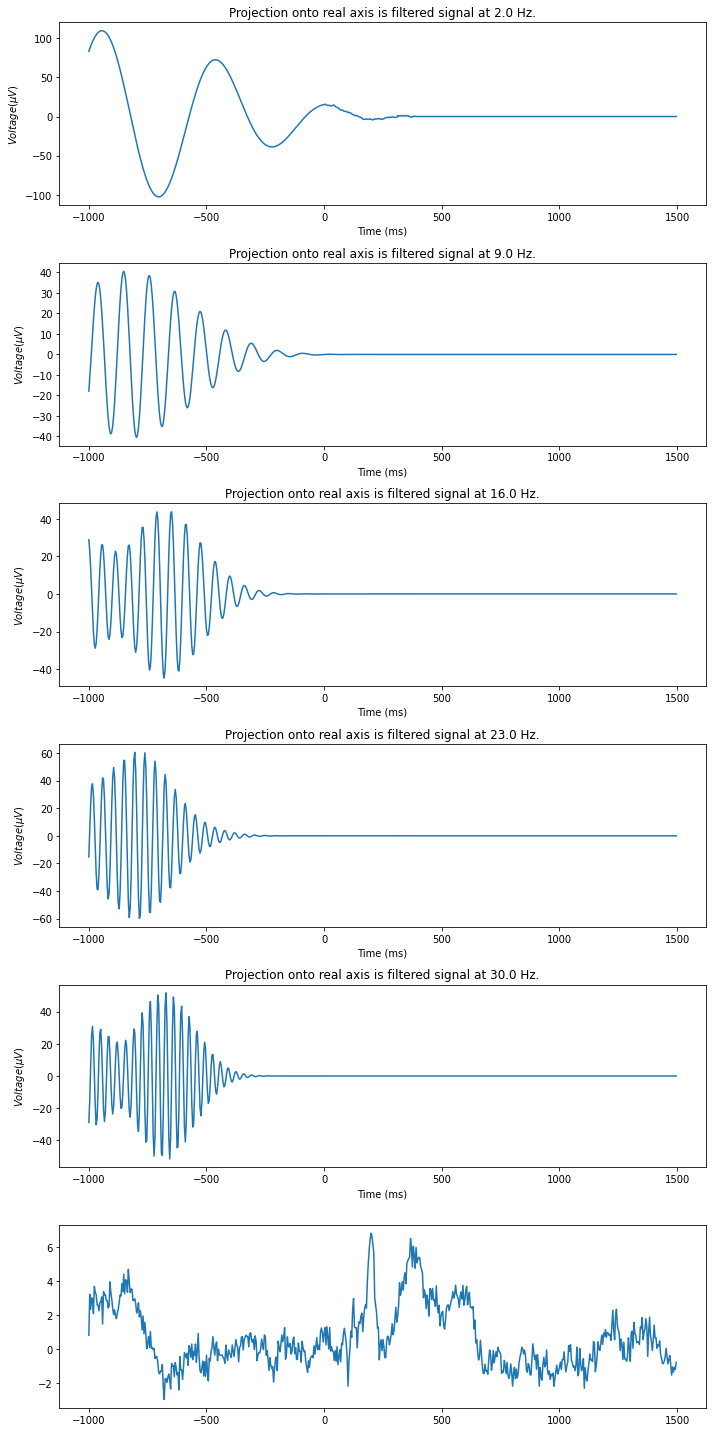

In [5]:
fig, ax = plt.subplots(6, figsize=(10, 20))
for idx, freq in enumerate(np.linspace(2, 30, 5)):
    make_wavelet(freq, ax[idx])
ax[5].plot(EEGtimes, np.mean(EEGdata[46,:,], axis=1))

fig.tight_layout() 

 Comparing the wavelet-convolved ERPs with the broadband ERP, we can observe the dynamics of the particular frequency. The result of convolution reflects activity that is maximal at the peak frequency of the wavelet. However, we can not obtain the dynamics of phase and power of frequencies with a wavelet.

 Also broadband ERP shows the dunamycs of frequencies other than the target frequency of the wavelet (surrounding frequencies). 

# Task 2

In [6]:
def make_wavelet2(frequency, subplt):
    time = np.arange(-1,1 + 1/EEGsrate,1/EEGsrate)
    s = (4/(2*pi*frequency))**2 #s squared here rather than next line
    wavelet = exp(2*1j*pi*frequency*time) * exp(-time**2./(2*s)/frequency)

    n_wavelet = len(wavelet)
    n_data = EEGpnts
    n_convolution = n_wavelet + n_data-1
    half_of_wavelet_size = len(wavelet)//2

    fft_wavelet = fft(wavelet,n_convolution)
    for channel in range(EEGdata.shape[0]):
        fft_data = fft(np.squeeze(EEGdata[channel,:,1]),n_convolution)# FCz

        #fft_data = np.mean(fft_data, axis=0)

        convolution_result_fft = ifft(fft_wavelet*fft_data,n_convolution)

        convolution_result_fft = convolution_result_fft[half_of_wavelet_size:-half_of_wavelet_size]
        power = np.absolute(convolution_result_fft)** 2
        phase = angle(convolution_result_fft)
        yield power, phase


In [7]:
result = np.empty(shape=(640, 5, 64, 2))

for idx, freq in enumerate(np.linspace(2, 30, 5)):
    tmp = list(make_wavelet2(freq, ax[idx]))
    for channel_idx in range(len(tmp)):
      result[:,idx,channel_idx,0] = tmp[channel_idx][0]
      result[:,idx,channel_idx,1] = tmp[channel_idx][1]
    

In [8]:

def closest(X, p):
    disp = X - p
    return np.argmin((disp*disp))

target = closest(EEGtimes, 180)
times2plot = [EEGtimes[target]]
times2plot

[179.6875]

In [9]:
!pip install mne
import mne 
from mne.viz import plot_topomap

biosemi_montage = mne.channels.make_standard_montage('biosemi64')
n_channels = len(biosemi_montage.ch_names)
fake_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=250.,
                            ch_types='eeg')

rng = np.random.RandomState(0)
data_fake = rng.normal(size=(n_channels, 1)) * 1e-6

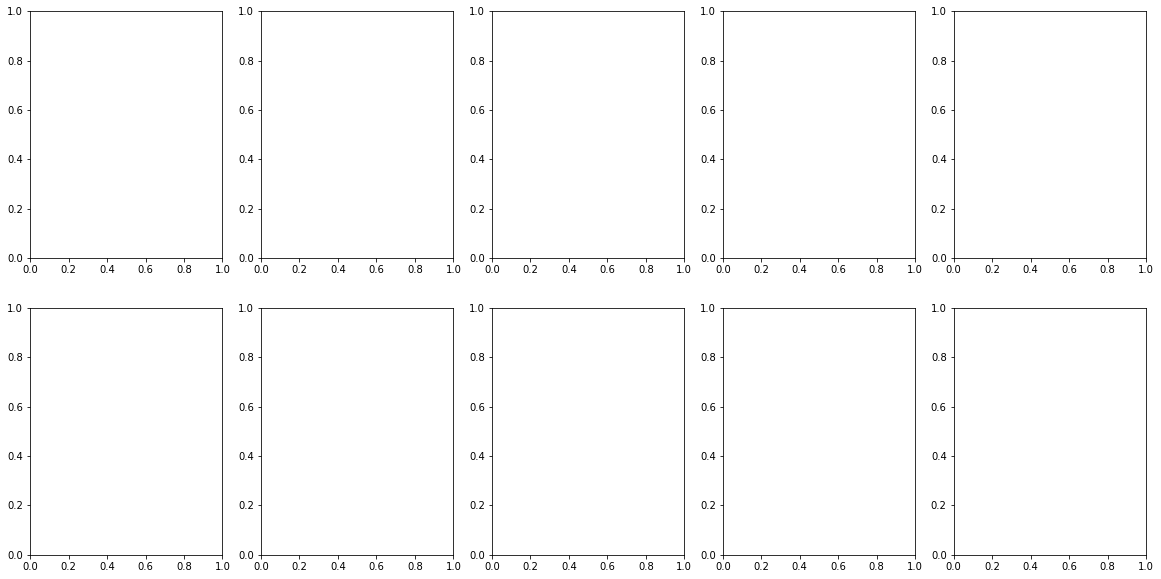

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10));
freqs = np.linspace(2, 30, 5);


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

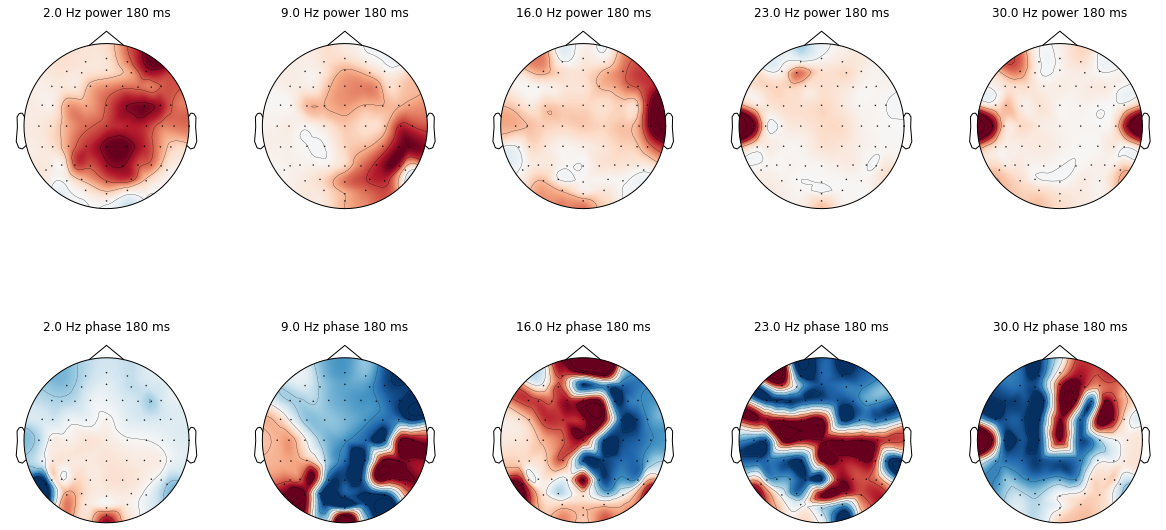

In [15]:
for i in range(5):
  for j in range(2):
    data_mne = mne.EvokedArray(result[:,i,:,j].T, fake_info)
    data_mne.times = EEGtimes
    data_mne.set_montage(biosemi_montage)
    data_mne.plot_topomap(target, axes=axes[j, i], ch_type='eeg', time_unit='s', colorbar=False);
    axes[j, i].set_title(f"{freqs[i]} Hz {('power', 'phase')[j]} 180 ms");


fig